In [1]:
from pathlib import Path
from typing import Callable, Optional
from dataclasses import dataclass

from opt_sim_dataset import OptSimilaritiesDataset

import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader, random_split

from tqdm.notebook import tqdm

In [3]:
data = OptSimilaritiesDataset(Path('./data'), 18, 26, 1, dtype=torch.float)

In [4]:
def test_dataset(data: OptSimilaritiesDataset):
    X, Y, blocks = [], [], []
    first_sample_len = len(list(Path('./data/block0/0').iterdir())) 
    for idx in range(first_sample_len + 1):
        x, y, block = data[idx] 
        X.append(x)
        Y.append(y)
        blocks.append(block)

    x0 = torch.load('./data/block0/0/0.pt')
    assert torch.allclose(x0, X[0]), 'Wrong x values'
    assert blocks[0] == 0, 'Wrong block value'

    x1 = torch.load('./data/block0/0/1.pt')
    assert torch.allclose(x1, X[1]), 'Wrong x values'
    assert blocks[1] == 0, 'Wrong block value'

    x2 = torch.load('./data/block0/1/0.pt')
    assert torch.allclose(x2, X[first_sample_len]), 'Wrong x values'
    assert blocks[first_sample_len] == 0, 'Wrong block values'

    y0 = F.cosine_similarity(
        torch.load('./data/block1/0/0.pt'),
        torch.load(f'./data/block{data.n + 1}/0/0.pt'),
        dim=-1
    )
    assert torch.isclose(Y[0], y0), 'Wrong y values'

    y1 = F.cosine_similarity(
        torch.load('./data/block1/0/1.pt'),
        torch.load(f'./data/block{data.n + 1}/0/1.pt'),
        dim=-1
    )
    assert torch.isclose(Y[1], y1), 'Wrong y values'

    y2 = F.cosine_similarity(
        torch.load('./data/block1/1/0.pt'),
        torch.load(f'./data/block{data.n + 1}/1/0.pt'),
        dim=-1
    )
    assert torch.isclose(Y[first_sample_len], y2), 'Wrong y values'

test_dataset(data)
print('All tests passed')

RuntimeError: BFloat16 did not match Float

In [7]:
@dataclass 
class MlpConfig:
    input_size: int
    output_size: int
    hidden_size: Optional[int] 

class LogReg(nn.Module):
    def __init__(self, config: MlpConfig):
        super(LogReg, self).__init__()
        self.fc = nn.Linear(config.input_size, config.output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, *args):
        return self.sigmoid(self.fc(x))

class SimpleMLP(nn.Module):
    def __init__(self, config: MlpConfig):
        super(SimpleMLP, self).__init__()
        assert config.hidden_size is not None 

        self.fc1 = nn.Linear(config.input_size, config.hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(config.hidden_size, config.output_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x, *args):
        # ignore args just to be compatible with PerBlockMlp
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

class PerBlockNet(nn.Module):
    def __init__(self, num_blocks: int, config: MlpConfig, block_net_cls: Callable[[MlpConfig], nn.Module]):
        super(PerBlockNet, self).__init__()
        self.num_blocks = num_blocks
        self.mlps = nn.ModuleList([block_net_cls(config) for _ in range(num_blocks)])
    
    def forward(self, x, blocks):
        out = torch.zeros(x.size(0))
        for idx, (xi, block) in enumerate(zip(x, blocks)):
            out[idx] = self.mlps[block](xi)
        
        return out.view(-1, 1) 

In [8]:
@torch.no_grad
def measure_loss(model, criterion, loader, device):
    model.eval()
    epoch_loss = 0
    for inputs, labels, blocks in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs, blocks).to(device)
        loss = criterion(outputs, labels)

        batch_size = outputs.numel()
        epoch_loss += loss.item() * batch_size / len(loader.dataset)

    return epoch_loss

In [9]:
def train_mlp(train_loader: DataLoader, val_loader: DataLoader, 
              model: SimpleMLP, criterion: Callable[[torch.Tensor, torch.Tensor], torch.Tensor], 
              num_epochs: int, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    for epoch in tqdm(range(num_epochs)):
        model.train()  
        epoch_loss = 0
        for inputs, labels, blocks in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            blocks = blocks.to(device)

            outputs = model(inputs, blocks).to(device)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = outputs.numel()
            epoch_loss += loss.item() * batch_size / len(train_loader.dataset)

        print(f'Epoch {epoch}: train_loss={epoch_loss:.4e}, val_loss={measure_loss(model, criterion, val_loader, device):.4e}') 
    
    return model

In [13]:
N = len(data)
test_len = int(N * 0.3)
train_and_val_data, test_data = random_split(data, [N - test_len, test_len])

batch_size = 16
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

config = MlpConfig(
    input_size=2048,
    hidden_size=512,
    output_size=1
)

In [14]:
for train_ratio in [0.6]: # torch.linspace(0.1, 0.6, 6):
    train_len = int(N * train_ratio)
    train_data, val_data = random_split(train_and_val_data, [train_len, N - train_len - test_len])

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    device = 'cuda'
    model = PerBlockNet(data.per_sample_len, config, SimpleMLP) 
    model = model.to(device)
    criterion = nn.MSELoss() 
    model = train_mlp(train_loader, val_loader, model, criterion, 4, device)

    print(f'{train_ratio=}, test loss = {measure_loss(model, criterion, test_loader, device):.4e}')

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train_loss=4.1739e-03, val_loss=2.4770e-03
Epoch 1: train_loss=3.2800e-03, val_loss=2.4774e-03
Epoch 2: train_loss=2.9061e-03, val_loss=2.4774e-03
Epoch 3: train_loss=2.7195e-03, val_loss=2.4774e-03
train_ratio=0.6, test loss = 2.5246e-03


In [15]:
per_block = [[] for _ in range(data.per_sample_len)]

for inputs, labels, blocks in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs, blocks)
    for block, out in zip(blocks, outputs):
        per_block[block].append(out.item())

In [16]:
for idx, x in enumerate(per_block):
    print(idx, len(x))

0 387
1 398
2 417
3 415
4 396
5 421
6 389
7 390
8 387
9 375
10 379
11 384
12 373
13 404
14 395
15 378


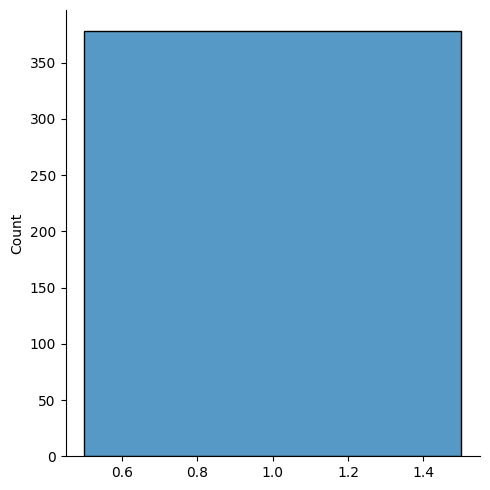

In [17]:
import seaborn as sns

sns.displot(per_block[-1])

In [18]:
simple_model = SimpleMLP(config).to(device)
train_mlp(train_loader, val_loader, simple_model, criterion, 4, device)
measure_loss(simple_model, criterion, test_loader, device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train_loss=3.1015e-03, val_loss=2.4774e-03
Epoch 1: train_loss=2.7195e-03, val_loss=2.4774e-03
Epoch 2: train_loss=2.7195e-03, val_loss=2.4774e-03
Epoch 3: train_loss=2.7195e-03, val_loss=2.4774e-03


0.0025245621240562732

In [19]:
per_block_simple = [[] for _ in range(data.per_sample_len)]

for inputs, labels, blocks in train_loader:
    inputs = inputs.to(device)
    outputs = simple_model(inputs, blocks)
    for block, out in zip(blocks, outputs):
        per_block_simple[block].append(out.item())

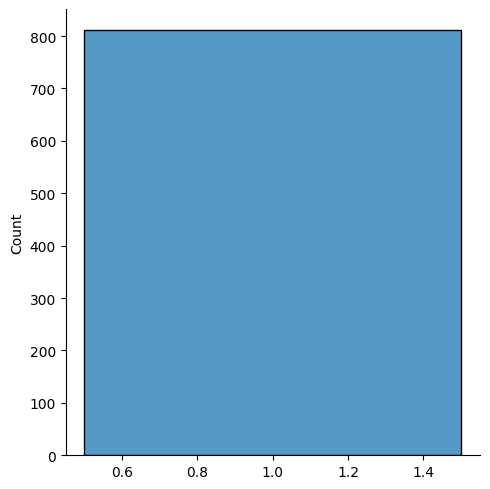

In [20]:
sns.displot(per_block_simple[-1])

In [21]:
per_block_actual = [[] for _ in range(data.per_sample_len)]
for _, y, blocks in train_loader:
    for block, sim in zip(blocks, y):
        per_block_actual[block].append(sim.item())

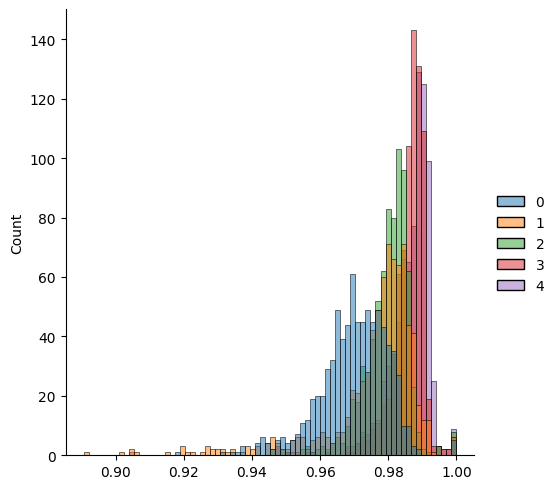

In [22]:
sns.displot(per_block_actual[:5]) 

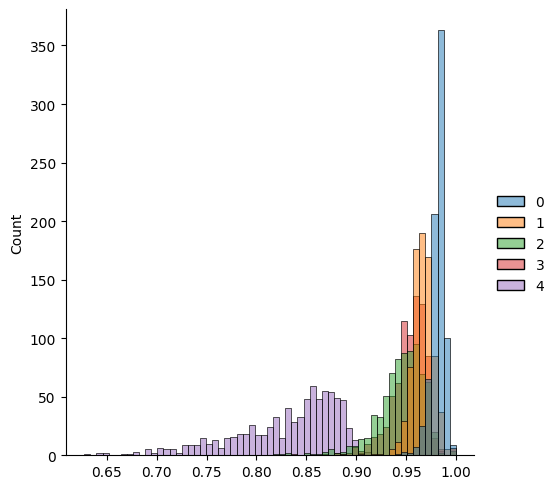

In [23]:
sns.displot(per_block_actual[-5:])

In [35]:
for idx, x in enumerate(per_block_actual):
    t = torch.tensor(x) * 100
    print(idx, f'{t.mean().item():.1f}', f'{t.var():.1f}') 

0 97.0 1.0
1 97.6 2.0
2 98.0 0.4
3 98.6 0.3
4 98.7 0.4
5 98.7 0.1
6 99.1 0.1
7 99.2 0.1
8 99.1 0.1
9 99.0 0.1
10 98.3 0.8
11 98.2 0.5
12 96.6 1.2
13 94.5 5.6
14 95.3 3.2
15 83.2 28.2


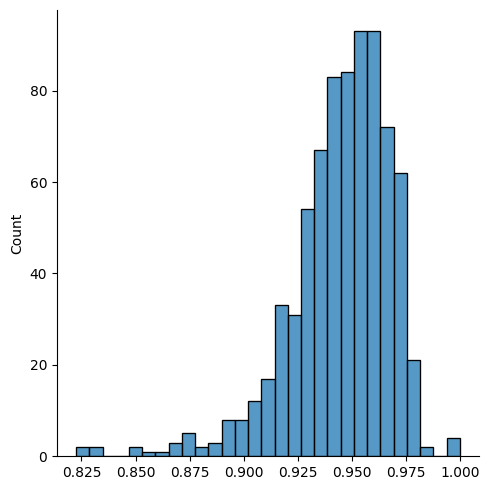

In [37]:
sns.displot(per_block_actual[13])

In [27]:
logreg = LogReg(config).to(device)
train_mlp(train_loader, val_loader, logreg, criterion, 4, device)
measure_loss(logreg, criterion, test_loader, device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train_loss=7.7576e-03, val_loss=2.5095e-03
Epoch 1: train_loss=2.6441e-03, val_loss=2.3763e-03
Epoch 2: train_loss=2.6721e-03, val_loss=2.3831e-03
Epoch 3: train_loss=2.6813e-03, val_loss=2.4462e-03


0.002483143728191173

In [28]:
logreg_better = PerBlockNet(data.per_sample_len, config, LogReg).to(device)
train_mlp(train_loader, val_loader, logreg_better, criterion, 4, device)
measure_loss(logreg_better, criterion, test_loader, device)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0: train_loss=8.1841e-03, val_loss=2.4715e-03
Epoch 1: train_loss=2.6995e-03, val_loss=2.3730e-03
Epoch 2: train_loss=2.6456e-03, val_loss=2.3817e-03
Epoch 3: train_loss=2.6765e-03, val_loss=2.3805e-03


0.002426298864728786